In [1]:
from math import log
import numpy as np

def calcEnt(dataSet):
# 计算划分后信息熵
    numEntries = len(dataSet)
    labelsCount = {}
    for d in dataSet:
        currentLabel = d[-1]
        labelsCount[currentLabel] = labelsCount.get(currentLabel,0)+1
    shannoEnt = 0.
    for _, key_count in labelsCount.items():
        prob = float(key_count/numEntries)
        shannoEnt += -prob*log(prob)
    return shannoEnt

def splitDataSet(dataSet,axis,value):
    readDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reduceFeatVec = featVec[:axis]
            reduceFeatVec.extend(featVec[axis+1:])
            readDataSet.append(reduceFeatVec)
    return readDataSet

def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0])-1
    baseEntropy = calcEnt(dataSet)
    bestFeature = -1
    bestInfoIncreasing = 0.0
    for i in range(numFeatures):
        featureVar = set([example[i] for example in dataSet])
        expectEntropy = 0
        # 期望的Ent,越小越有序
        for value in featureVar:
            subDataSet = splitDataSet(dataSet,i,value)
            splitProb = len(subDataSet)/len(dataSet)
            expectEntropy += splitProb * calcEnt(subDataSet)
        infoGain = baseEntropy - expectEntropy
        if infoGain > bestInfoIncreasing:
            bestInfoIncreasing = infoGain
            bestFeature = i
    return bestFeature


In [3]:
import operator
import copy

def majorityCnt(classList):
    classCount={}
    for vote in classList:
        if vote not in classCount.keys(): classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]

def createTree(dataSet,labels):
    var_labels= copy.deepcopy(labels) # 深拷贝
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList):
        return classList[0] #stop splitting when all of the classes are equal
    if len(dataSet[0]) == 1: #stop splitting when there are no more features in dataSet
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = var_labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(var_labels[bestFeat]) # 这里简单删除了属性，不会再考虑
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = var_labels[:]       #copy all of labels, so trees don't mess up existing labels
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value),subLabels)
    return myTree

def createDataSet():
    dataSet = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing', 'flippers']
    # change to discrete values
    return dataSet, labels


if __name__ == '__main__':
    d,l = createDataSet()
    T = createTree(d,l)
    print(T)

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}


{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}, '3': 'maybe'}}
2


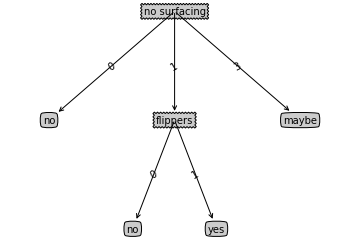

In [49]:
import matplotlib.pyplot as plt

decisionNode = dict(boxstyle='sawtooth',fc='0.8')
arrow_args = dict(arrowstyle='<-')
leafNode = dict(boxstyle='round4',fc='0.8')

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction',
                            xytext=centerPt, textcoords='axes fraction',
                            va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)

def createPlot_old():
   fig = plt.figure(1, facecolor='white')
   fig.clf()
   createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses
   plotNode('a decision node', (0.5, 0.1), (0.1, 0.5), decisionNode)
   plotNode('a leaf node', (0.8, 0.1), (0.3, 0.8), leafNode)
   plt.show()

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    #no ticks
    #createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()

def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]) == dict:
            # test to see if the n# odes are dictonaires, if not they are leaf nodes
            # type(secondDict[key]).__name__ == 'dict'
            numLeafs += getNumLeafs(secondDict[key])
        else:   numLeafs +=1
    return numLeafs

def getTreeDepth(myTree):
    maxdepth = 0
    branches = myTree[list(myTree.keys())[0]]
    # 属性值-label一定是dict
    for _, subTree in branches.items():
        if type(subTree).__name__ == 'dict':
            subdepth = 1 + getTreeDepth(subTree)
        else:
            subdepth = 1
        maxdepth = max(maxdepth,subdepth)
    return maxdepth


def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

def plotTree(myTree, parentPt, nodeTxt):#if the first key tells you what feat was split on
    numLeafs = getNumLeafs(myTree)  #this determines the x width of this tree
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]     #the text label for this node should be this
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            plotTree(secondDict[key],cntrPt,str(key))        #recursion
        else:   #it's a leaf node print the leaf node
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

from trees import createDataSet,createTree
if __name__ == '__main__':
    d, l = createDataSet()
    T = createTree(d, l)
    T = {'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}
    T['no surfacing']['3'] = 'maybe'
    print(T)
    print(getTreeDepth(T))
    createPlot(T)

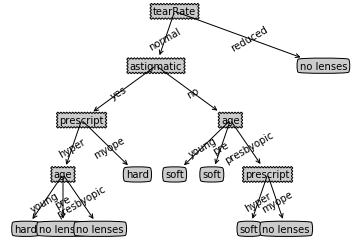

[['young', 'myope', 'no', 'reduced', 'no lenses'], ['young', 'myope', 'no', 'normal', 'soft']]


In [117]:
with open('lenses.txt','r') as f:
    Data = [line.strip().split('\t') for line in f]
L = ['age','prescript','astigmatic','tearRate']
T = createTree(Data, L)
createPlot(T)
import numpy as np
print(Data[:2])
Data = np.array(Data)


In [118]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
import pandas as pd
Data = pd.DataFrame(Data)
L.append('answer')
Data.columns = L
Data.head()


,age,prescript,astigmatic,tearRate,answer
0,young,myope,no,reduced,no lenses
1,young,myope,no,normal,soft
2,young,myope,yes,reduced,no lenses
3,young,myope,yes,normal,hard
4,young,hyper,no,reduced,no lenses


In [119]:

from sklearn.preprocessing import LabelEncoder
Data.iloc[:,-1] = LabelEncoder().fit_transform(Data.iloc[:,-1])
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder() # 适应于有序变量，对于树模型不太重要区分
Data.iloc[:,:-1] = encoder.fit_transform(Data.iloc[:,:-1])
print(encoder._categories)
Data.head()
# clf.fit(Data,L)

auto


,age,prescript,astigmatic,tearRate,answer
0,2.0,1.0,0.0,1.0,1
1,2.0,1.0,0.0,0.0,2
2,2.0,1.0,1.0,1.0,1
3,2.0,1.0,1.0,0.0,0
4,2.0,0.0,0.0,1.0,1


In [120]:
from sklearn.preprocessing import OneHotEncoder
encoder2 = OneHotEncoder(categories='auto') # 为了学习而强行使用下
Data.iloc[:,1].values
tem = encoder2.fit_transform(Data.iloc[:,1].values.reshape(-1,1)).toarray()
tem = pd.concat([Data.iloc[:,0],pd.DataFrame(tem),Data.iloc[:,2:]],axis=1)
tem
# encoder2.get_feature_names()



,age,0,1,astigmatic,tearRate,answer
0,2.0,0.0,1.0,0.0,1.0,1
1,2.0,0.0,1.0,0.0,0.0,2
2,2.0,0.0,1.0,1.0,1.0,1
3,2.0,0.0,1.0,1.0,0.0,0
4,2.0,1.0,0.0,0.0,1.0,1
5,2.0,1.0,0.0,0.0,0.0,2
6,2.0,1.0,0.0,1.0,1.0,1
7,2.0,1.0,0.0,1.0,0.0,0
8,0.0,0.0,1.0,0.0,1.0,1
9,0.0,0.0,1.0,0.0,0.0,2


In [121]:
Data = tem

sklearn 实现

In [125]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(Data.iloc[:,:-1],Data.iloc[:,-1])
Data.columns

Index(['age', 0, 1, 'astigmatic', 'tearRate', 'answer'], dtype='object')

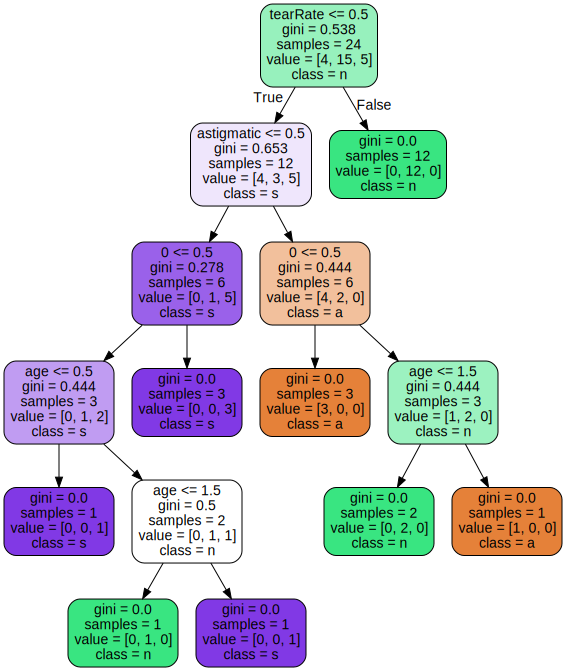

In [126]:
import graphviz
dot_data = tree.export_graphviz(clf,feature_names=Data.columns[:-1],class_names=Data.columns[-1]
                                ,filled=True
                                ,rounded=True)
graph = graphviz.Source(dot_data)
graph